# ENVIRONMENT

In [6]:
!pip install mlxtend

     |████████████████████████████████| 1.3 MB 5.2 MB/s eta 0:00:01


In [392]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# suppress scientific notation in Pandas
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)
pd.set_option("precision", 3)
pd.set_option("display.max_colwidth", None)

plt.rcParams["figure.figsize"] = [12, 10]
plt.rcParams["figure.dpi"] = 150

sns.set()
sns.set_context("notebook", rc={"lines.linewidth": 2.5})
sns.set_style("whitegrid")

import warnings

warnings.filterwarnings("ignore")

RANDOM_STATE = 1

original_df = pd.read_csv("./src/churn/teleco_market_basket.csv")
df = original_df.copy()


# Part 0: Data Exploration

In [66]:
df.head()

,Item01,Item02,Item03,Item04,Item05,Item06,Item07,Item08,Item09,Item10,Item11,Item12,Item13,Item14,Item15,Item16,Item17,Item18,Item19,Item20
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Logitech M510 Wireless mouse,HP 63 Ink,HP 65 ink,nonda USB C to USB Adapter,10ft iPHone Charger Cable,HP 902XL ink,Creative Pebble 2.0 Speakers,Cleaning Gel Universal Dust Cleaner,Micro Center 32GB Memory card,YUNSONG 3pack 6ft Nylon Lightning Cable,TopMate C5 Laptop Cooler pad,Apple USB-C Charger cable,HyperX Cloud Stinger Headset,TONOR USB Gaming Microphone,Dust-Off Compressed Gas 2 pack,3A USB Type C Cable 3 pack 6FT,HOVAMP iPhone charger,SanDisk Ultra 128GB card,FEEL2NICE 5 pack 10ft Lighning cable,FEIYOLD Blue light Blocking Glasses
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Apple Lightning to Digital AV Adapter,TP-Link AC1750 Smart WiFi Router,Apple Pencil,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
df.shape

(15002, 20)

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15002 entries, 0 to 15001
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Item01  7501 non-null   object
 1   Item02  5747 non-null   object
 2   Item03  4389 non-null   object
 3   Item04  3345 non-null   object
 4   Item05  2529 non-null   object
 5   Item06  1864 non-null   object
 6   Item07  1369 non-null   object
 7   Item08  981 non-null    object
 8   Item09  654 non-null    object
 9   Item10  395 non-null    object
 10  Item11  256 non-null    object
 11  Item12  154 non-null    object
 12  Item13  87 non-null     object
 13  Item14  47 non-null     object
 14  Item15  25 non-null     object
 15  Item16  8 non-null      object
 16  Item17  4 non-null      object
 17  Item18  4 non-null      object
 18  Item19  3 non-null      object
 19  Item20  1 non-null      object
dtypes: object(20)
memory usage: 2.3+ MB


In [375]:
pd.DataFrame(df.isnull().sum(), columns=["# NaNs"])

,# NaNs
Item01,0
Item02,1754
Item03,3112
Item04,4156
Item05,4972
Item06,5637
Item07,6132
Item08,6520
Item09,6847
Item10,7106


In [383]:
f"{df.isnull().sum().sum():,} Total NaN Cells"


'120,657 Total NaN Cells'

In [322]:
df.shape
df.head()

(7501, 20)

,Item01,Item02,Item03,Item04,Item05,Item06,Item07,Item08,Item09,Item10,Item11,Item12,Item13,Item14,Item15,Item16,Item17,Item18,Item19,Item20
1,Logitech M510 Wireless mouse,HP 63 Ink,HP 65 ink,nonda USB C to USB Adapter,10ft iPHone Charger Cable,HP 902XL ink,Creative Pebble 2.0 Speakers,Cleaning Gel Universal Dust Cleaner,Micro Center 32GB Memory card,YUNSONG 3pack 6ft Nylon Lightning Cable,TopMate C5 Laptop Cooler pad,Apple USB-C Charger cable,HyperX Cloud Stinger Headset,TONOR USB Gaming Microphone,Dust-Off Compressed Gas 2 pack,3A USB Type C Cable 3 pack 6FT,HOVAMP iPhone charger,SanDisk Ultra 128GB card,FEEL2NICE 5 pack 10ft Lighning cable,FEIYOLD Blue light Blocking Glasses
3,Apple Lightning to Digital AV Adapter,TP-Link AC1750 Smart WiFi Router,Apple Pencil,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,UNEN Mfi Certified 5-pack Lightning Cable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Cat8 Ethernet Cable,HP 65 ink,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Dust-Off Compressed Gas 2 pack,Screen Mom Screen Cleaner kit,Moread HDMI to VGA Adapter,HP 62XL Tri-Color ink,Apple USB-C Charger cable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
# Instantiate transaction encoder
encoder = TransactionEncoder().fit(original_df)
# pd.DataFrame(encoder)

# One-hot encode itemsets by applying fit and transform
onehot = encoder.transform(original_df)

# Convert one-hot encoded data to DataFrame
onehot = pd.DataFrame(onehot, columns = encoder.columns_)
print(onehot)

# Computing support for single items
print(onehot.mean())

           0      1      2      3      4      5      6      7      8      9  \
0       True   True  False  False  False  False  False  False  False  False   
1       True  False   True  False  False  False  False  False  False  False   
2       True  False  False   True  False  False  False  False  False  False   
3       True  False  False  False   True  False  False  False  False  False   
4       True  False  False  False  False   True  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
14997  False  False  False  False  False  False  False  False  False  False   
14998  False  False  False  False  False  False  False  False  False  False   
14999  False  False  False  False  False  False  False  False  False  False   
15000  False  False  False  False  False  False  False  False  False  False   
15001  False  False  False  False  False  False  False  False  False  False   

           I      e      m      t  
0       True   

## Market Basket Analysis Examples

In [ ]:
How to compute association rules
# Import Apriori algorithm
from mlxtend.frequent_patterns import apriori, association_rules
# Load one-hot encoded novelty gifts data
onehot = pd.read_csv('datasets/online_retail_onehot.csv')
# Apply Apriori algorithm
frequent_itemsets = apriori(onehot,
use_colnames=True,
min_support=0.0001)
# Compute association rules
rules = association_rules(frequent_itemsets,
metric = "support",
min_threshold = 0.0)

# The importance of pruning
# Print the rules.
print(rules)

# Print the frequent itemsets.
print(frequent_itemsets)

# Compute association rules
rules = association_rules(frequent_itemsets,
metric = "support",
min_threshold = 0.001)
# Print the rules.
print(rules)

# Exploring the set of rules
print(rules.columns)

print(rules[['antecedents','consequents']])

# Pruning with other metrics
# Compute association rules
rules = association_rules(frequent_itemsets,
metric = "antecedent support",
min_threshold = 0.002)
# Print the number of rules.
print(len(rules))

In [ ]:
# Generating a heatmap

In [ ]:
# scatterplot Support versus confidence
# What can we learn from scatterplots?
    # Identify natural thresholds in data.
    # Not possible with heatmaps or other visualizations.
    # Visualize entire dataset.
    # Not limited to small number of rules.
    # Use  ndings to prune.
    # Use natural thresholds and pa erns to prune.

In [ ]:
# parallel coordinate plots

In [ ]:
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

df = pd.read_excel('http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx')
df.head()

#  There is a little cleanup, we need to do. First, some of the descriptions have spaces that need to be removed. We’ll also drop the rows that don’t have invoice numbers and remove the credit transactions (those with invoice numbers containing C).
df['Description'] = df['Description'].str.strip()
df.dropna(axis=0, subset=['InvoiceNo'], inplace=True)
df['InvoiceNo'] = df['InvoiceNo'].astype('str')
df = df[~df['InvoiceNo'].str.contains('C')]

# After the cleanup, we need to consolidate the items into 1 transaction per row with each product 1 hot encoded. For the sake of keeping the data set small, I’m only looking at sales for France. However, in additional code below, I will compare these results to sales from Germany. Further country comparisons would be interesting to investigate.
basket = (df[df['Country'] =="France"]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

# There are a lot of zeros in the data but we also need to make sure any positive values are converted to a 1 and anything less the 0 is set to 0. This step will complete the one hot encoding of the data and remove the postage column (since that charge is not one we wish to explore):

def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units)
basket_sets.drop('POSTAGE', inplace=True, axis=1)

#  Now that the data is structured properly, we can generate frequent item sets that have a support of at least 7% (this number was chosen so that I could get enough useful examples):
frequent_itemsets = apriori(basket_sets, min_support=0.07, use_colnames=True)


# The final step is to generate the rules with their corresponding support, confidence and lift:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.head()

# That’s all there is to it! Build the frequent items using apriori then build the rules with association_rules .

# Now, the tricky part is figuring out what this tells us. For instance, we can see that there are quite a few rules with a high lift value which means that it occurs more frequently than would be expected given the number of transaction and product combinations. We can also see several where the confidence is high as well. This part of the analysis is where the domain knowledge will come in handy. Since I do not have that, I’ll just look for a couple of illustrative examples.

# We can filter the dataframe using standard pandas code. In this case, look for a large lift (6) and high confidence (.8):
rules[ (rules['lift'] >= 6) &
       (rules['confidence'] >= 0.8) ]

# In looking at the rules, it seems that the green and red alarm clocks are purchased together and the red paper cups, napkins and plates are purchased together in a manner that is higher than the overall probability would suggest. At this point, you may want to look at how much opportunity there is to use the popularity of one product to drive sales of another. For instance, we can see that we sell 340 Green Alarm clocks but only 316 Red Alarm Clocks so maybe we can drive more Red Alarm Clock sales through recommendations?

basket['ALARM CLOCK BAKELIKE GREEN'].sum()
basket['ALARM CLOCK BAKELIKE RED'].sum()

# What is also interesting is to see how the combinations vary by country of purchase. Let’s check out what some popular combinations might be in Germany:

basket2 = (df[df['Country'] =="Germany"]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

basket_sets2 = basket2.applymap(encode_units)
basket_sets2.drop('POSTAGE', inplace=True, axis=1)
frequent_itemsets2 = apriori(basket_sets2, min_support=0.05, use_colnames=True)
rules2 = association_rules(frequent_itemsets2, metric="lift", min_threshold=1)

rules2[ (rules2['lift'] >= 4) &
        (rules2['confidence'] >= 0.5)]

✅⭐👍👎

### Scenario 1

One of the most critical factors in customer relationship management that directly affects a company’s long-term profitability is understanding its customers. When a company can better understand its customer characteristics, it is better able to target products and marketing campaigns for customers, resulting in better profits for the company in the long term.

 

You are an analyst for a telecommunications company that wants to better understand the characteristics of its customers. You have been asked to perform a market basket analysis to analyze customer data to identify key associations of your customer purchases, ultimately allowing better business and strategic decision-making.

 

### Scenario 2

One of the most critical factors in patient relationship management that directly affects a hospital’s long-term cost effectiveness is understanding its patients and the conditions leading to hospital admissions. When a hospital can better understand its patients’ characteristics, it is better able to target treatment to patients, resulting in more effective cost of care for the hospital in the long term.

 

You are an analyst for a hospital that wants to better understand the characteristics of its patients. You have been asked to perform a market basket analysis to analyze patient data to identify key associations of your patients, ultimately allowing better business and strategic decision-making for the hospital.


- I'm very frustrated and task 3. I cannot find the information needed to create these 119/120 columns. I have the rows. I honestly have no clue what I'm missing. I cannot find anything in the course materials that is helpful with this dataset.
    - Hello Megan, Using R, the data needs to be converted to factor and transformed into a transactional dataset before using the Apriori algorithm Reminder. Please look up "Transactionalizing the online data frame" in chapter 2 of the datacamp material (Market Basket Analysis in R)

- I'm working on Task 3 teleco MBA , does anyone have any tips or sources for how to clean the data? I understand we have to remove the blank rows which brings the count down to 7501 but I can't figure out how or why we are removing a column.
    - Please see some tips below: 1. Read dataset into R 2. Explore data structure 3. Check for missing values 4. Remove empty rows or columns 5. Change data to factors 6. Verify that missing values are removed 7. Create a list 8. Create a dataframe for use with apriori 9.
    - Your original mba data sets contained character vectors with categorical variables. Transforming your dataset from character vector to factor vector will create a suitable data structure for mba analysis. I encourage you to read more about character vector and factor vector, how to factor variables in R. 
    
- I'm currently working on Task 3 and find the instructions for the task to be very vague and the datacamp material for basket analysis to be inadequate. What have others found helpful both in terms of finding the proper Python packages to use to satisfy the Task, but also getting a clear explanation for what is expected for the Task 3 analysis?
    - Hello Nathan, Tips: 1. Follow the task overview and watch Video Resources in course “Announcements” 2. Schedule time with your CI if further clarifications are needed 3. Don’t forget to download either the teleco_market_basket.csv or medical_market_basket.csv from the Data Files and Associated Data Dictionary Files in task 3 4. Data transformation (cleaned data for analysis should be 7501 rows and 119 columns or items) 5. Joining the python community may help
    
- Hi cohort! - the "teleco_market_basket" csv for Task 3 seems to have a return resulting in a blank row b/t observations. Was that intentional, or is it just something we should adjust for on loading?
    - This is intentional for the dataset provided.

- Import Info: Please download the Market Basket Analysis or D212 task 3 dataset from the “Data Sets and Associated Data Dictionaries link in the introduction paragraph of Task 3. Market Basket Analysis must use transactional dataset to complete this task. 

https://towardsdatascience.com/a-gentle-introduction-on-market-basket-analysis-association-rules-fa4b986a40ce

- density: The percentage of non-empty cells in the sparse matrix. In another words, the total number of items that are purchased divided by the total number of possible items in that matrix. We can calculate how many items were purchased using density like so: 19296 X 7881 X 0.0022

- The most frequent items should be the same as our results in Figure 3.

- Looking at the size of the transactions: 2247 transactions were for just 1 item, 1147 transactions for 2 items, all the way up to the biggest transaction: 1 transaction for 420 items. This indicates that most customers buy a small number of items in each transaction.

- The distribution of the data is right skewed.

- Let’s have a look at the item frequency plot, which should be in aligned with Figure 3.

In [ ]:
- We use the Apriori algorithm in Arules library to mine frequent itemsets and association rules. The algorithm employs level-wise search for frequent itemsets.
- We pass supp=0.001 and conf=0.8 to return all the rules that have a support of at least 0.1% and confidence of at least 80%.
- We sort the rules by decreasing confidence.
- Have a look at the summary of the rules.

rules <- apriori(tr, parameter = list(supp=0.001, conf=0.8))
rules <- sort(rules, by='confidence', decreasing = TRUE)
summary(rules)

In [ ]:
The summary of the rules gives us some very interesting information:

The number of rules: 89,697.
The distribution of rules by length: a length of 6 items has the most rules.
The summary of quality measures: ranges of support, confidence, and lift.
The information on data mining: total data mined, and the minimum parameters we set earlier.
We have 89,697 rules. I don’t want to print them all, so let’s inspect the top 10

In [ ]:
And plot these top 10 rules.



# Part ✅ I: Research Question

## A.  Describe the purpose of this data mining report by doing the following:

### ✅ 1.  Propose one question relevant to a real-world organizational situation that you will answer using market basket analysis.

Gibson Telecom wants to experiment with a customer rewards program to reduce churn, drive customer signups and gamify loyalty for customers. To show appreciation for a customer's loyalty, each year on a customer's birthday, Gibson would like to present several discounted tech item bundles for a customer to choose from. Additionally, Gibson will offer these bundles to new customers as a thank you for signing up. Gibson executives would like to know if analysts can mine customer transaction data to identify key product associations that can help develop product bundles. 


### ✅ 2.  Define one goal of the data analysis. Ensure that your goal is reasonable within the scope of the scenario and is represented in the available data.
The primary data analysis goal is to identify 3 product bundles of associated tech items that the marketing can offer to existing customers on their birthday and new customers upon signup.

# Part II: Market Basket Justification

## B.  Explain the reasons for using market basket analysis by doing the following:

### ✅ 1.  Explain how market basket analyzes the selected dataset. Include expected outcomes.
Market Basket Analysis is an unsupervised learning association analysis technique that identifies patterns of items within a data set. This technique allows individuals to mine transaction data and uncover unexpected transaction patterns (https://pbpython.com/market-basket-analysis.html).

Market Basket Analysis analyzes the selected dataset by using the Apriori algorithm to mine the one-hot encoded customer transaction records to where all the items purchased together are represented in one row. The outcome of this analysis is a table of frequent item sets and association rules with antecedents and consequents (https://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/). 

Large transaction datasets will generate a large volume of frequent itemsets. Consequently, analysts will discover most of these itemsets and rules provide little actionable insight. As a result, it's important to reduce the rulesets by filtering the association rules. To filter the rulesets, we can use the mlxtend.apriori function's min_support parameter to control the ruleset's relative frequency threshold (https://pbpython.com/market-basket-analysis.html). This parameter filters out any frequent itemsets that occur together below a certain percentage of all transactions (https://towardsdatascience.com/a-gentle-introduction-on-market-basket-analysis-association-rules-fa4b986a40ce).

The expected outcome of the apriori function is a data frame of the frequent itemsets and the support value for the itemset. The next step in the analysis is to generate rules with antecedents, consequents, and their corresponding support, confidence, and lift metrics (https://pbpython.com/market-basket-analysis.html).

Overall, the expected outcome of this analysis is to uncover frequent transaction patterns for Gibson Telecom customers. From there, Gibson's marketing team can use their intuition and the frequent itemsets to build discount for customer bundles.



### ✅ 2.  Provide one example of transactions in the dataset.

In [389]:
df.head(1)

,Item01,Item02,Item03,Item04,Item05,Item06,Item07,Item08,Item09,Item10,Item11,Item12,Item13,Item14,Item15,Item16,Item17,Item18,Item19,Item20
1,Logitech M510 Wireless mouse,HP 63 Ink,HP 65 ink,nonda USB C to USB Adapter,10ft iPHone Charger Cable,HP 902XL ink,Creative Pebble 2.0 Speakers,Cleaning Gel Universal Dust Cleaner,Micro Center 32GB Memory card,YUNSONG 3pack 6ft Nylon Lightning Cable,TopMate C5 Laptop Cooler pad,Apple USB-C Charger cable,HyperX Cloud Stinger Headset,TONOR USB Gaming Microphone,Dust-Off Compressed Gas 2 pack,3A USB Type C Cable 3 pack 6FT,HOVAMP iPhone charger,SanDisk Ultra 128GB card,FEEL2NICE 5 pack 10ft Lighning cable,FEIYOLD Blue light Blocking Glasses


### ✅ 3.  Summarize one assumption of market basket analysis.
One assumption about market basket analysis is that the analysis requires that the data is in a specific format. For example, the data should be in a wide format where each row represents a single transaction and each column represents a unique item that may or may not have been in the transaction. Furthermore, the dataset should be 1-hot encoded to indicate if the item was in the transaction (https://pbpython.com/market-basket-analysis.html).        

# Part III: Data Preparation and Analysis

## C.  Prepare and perform market basket analysis by doing the following:

### 1.  Transform the dataset to make it suitable for market basket analysis. Include a copy of the cleaned dataset.

#### Data Prep - find rows that are all Null

In [507]:
df = original_df.copy()

# trim all strings
df = df.select_dtypes(['object']).applymap(lambda x: x.strip() if isinstance(x, str) else x)

# Remove rows with all missing values.
df = df.dropna(axis = 0, how = 'all')

# Remove columns with all missing values.
df = df.dropna(axis = 1, how = 'all')

# convert row of columns to list of items
transactions = df.T.apply(lambda x: x.dropna().tolist()).tolist()

In [515]:
transactions[:2]

df.shape

[['Logitech M510 Wireless mouse',
  'HP 63 Ink',
  'HP 65 ink',
  'nonda USB C to USB Adapter',
  '10ft iPHone Charger Cable',
  'HP 902XL ink',
  'Creative Pebble 2.0 Speakers',
  'Cleaning Gel Universal Dust Cleaner',
  'Micro Center 32GB Memory card',
  'YUNSONG 3pack 6ft Nylon Lightning Cable',
  'TopMate C5 Laptop Cooler pad',
  'Apple USB-C Charger cable',
  'HyperX Cloud Stinger Headset',
  'TONOR USB Gaming Microphone',
  'Dust-Off Compressed Gas 2 pack',
  '3A USB Type C Cable 3 pack 6FT',
  'HOVAMP iPhone charger',
  'SanDisk Ultra 128GB card',
  'FEEL2NICE 5 pack 10ft Lighning cable',
  'FEIYOLD Blue light Blocking Glasses'],
 ['Apple Lightning to Digital AV Adapter',
  'TP-Link AC1750 Smart WiFi Router',
  'Apple Pencil']]

(7501, 20)

#### One-Hot Encode Itemsets

In [523]:
# Instantiate transaction encoder and one-hot encode itemsets
onehot = TransactionEncoder().fit_transform(transactions)
onehot

# Convert one-hot encoded data to DataFrame with 0's and 1's
onehot_df = pd.DataFrame(onehot, columns = encoder.columns_).replace({True: 1, False: 0})

onehot_df.head()

# cleaned data for analysis should be 7501 rows and 119 columns or items
onehot_df.shape

array([[ True, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

,10ft iPHone Charger Cable,10ft iPHone Charger Cable 2 Pack,3 pack Nylon Braided Lightning Cable,3A USB Type C Cable 3 pack 6FT,5pack Nylon Braided USB C cables,ARRIS SURFboard SB8200 Cable Modem,Anker 2-in-1 USB Card Reader,Anker 4-port USB hub,Anker USB C to HDMI Adapter,Apple Lightning to Digital AV Adapter,Apple Lightning to USB cable,Apple Magic Mouse 2,Apple Pencil,Apple Pencil 2nd Gen,Apple Power Adapter Extension Cable,Apple USB-C Charger cable,AutoFocus 1080p Webcam,BENGOO G90000 headset,Blue Light Blocking Glasses,Blue Light Blocking Glasses 2pack,Brother Genuine High Yield Toner Cartridge,Cat 6 Ethernet Cable 50ft,Cat8 Ethernet Cable,CicTsing MM057 2.4G Wireless Mouse,Cleaning Gel Universal Dust Cleaner,Creative Pebble 2.0 Speakers,DisplayPort ot HDMI adapter,Dust-Off Compressed Gas,Dust-Off Compressed Gas 2 pack,FEEL2NICE 5 pack 10ft Lighning cable,FEIYOLD Blue light Blocking Glasses,Falcon Dust Off Compressed Gas,HOVAMP Mfi 6pack Lightning Cable,HOVAMP iPhone charger,HP 61 2 pack ink,HP 61 Tri-color ink,HP 61 ink,HP 62XL Tri-Color ink,HP 62XL ink,HP 63 Ink,HP 63 Tri-color ink,HP 63XL Ink,HP 63XL Tri-color ink,HP 64 Tri-Color ink,HP 64 ink,HP 65 ink,HP 902XL ink,HP 952 ink,HP ENVY 5055 printer,HP952XL ink,...,Premium Nylon USB Cable,RUNMUS Gaming Headset,SAMSUNG 128GB card,SAMSUNG 256 GB card,SAMSUNG EVO 32GB card,SAMSUNG EVO 64GB card,Sabrent 4-port USB 3.0 hub,SanDisk 128GB Ultra microSDXC card,SanDisk 128GB card,SanDisk 128GB microSDXC card,SanDisk 32GB Ultra SDHC card,SanDisk 32GB card,SanDisk Extreme 128GB card,SanDisk Extreme 256GB card,SanDisk Extreme 32GB 2pack card,SanDisk Extreme Pro 128GB card,SanDisk Extreme Pro 64GB card,SanDisk Ultra 128GB card,SanDisk Ultra 256GB card,SanDisk Ultra 400GB card,SanDisk Ultra 64GB card,Screen Mom Screen Cleaner kit,Stylus Pen for iPad,Syntech USB C to USB Adapter,TONOR USB Gaming Microphone,TP-Link AC1750 Smart WiFi Router,TP-Link AC4000 WiFi router,TopMate C5 Laptop Cooler pad,UNEN Mfi Certified 5-pack Lightning Cable,USB 2.0 Printer cable,USB C to USB Male Adapter,USB Type C Cable,USB Type C to USB-A Charger cable,VIVO Dual LCD Monitor Desk mount,VicTsing Mouse Pad,VicTsing Wireless mouse,Vsco 70 pack stickers,Webcam with Microphone,XPOWER A-2 Air Pump blower,YUNSONG 3pack 6ft Nylon Lightning Cable,hP 65 Tri-color ink,iFixit Pro Tech Toolkit,iPhone 11 case,iPhone 12 Charger cable,iPhone 12 Pro case,iPhone 12 case,iPhone Charger Cable Anker 6ft,iPhone SE case,nonda USB C to USB Adapter,seenda Wireless mouse
0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


(7501, 119)

#### Compute frequent itemsets using the Apriori algorithm

In [412]:
# Compute frequent itemsets using the Apriori algorithm
frequent_itemsets = apriori(onehot_df, min_support = 0.01, max_len = None, use_colnames = True).sort_values(by="support", ascending=False)

frequent_itemsets["# antecedents"] = frequent_itemsets["itemsets"].apply(lambda x: len(x))
# frequent_itemsets = fpgrowth(onehot_df, min_support=0.01, use_colnames=True)
frequent_itemsets


,support,itemsets,# antecedents
18,0.24,(Dust-Off Compressed Gas 2 pack),1
8,0.18,(Apple Pencil),1
66,0.17,(VIVO Dual LCD Monitor Desk mount),1
63,0.17,(USB 2.0 Printer cable),1
23,0.16,(HP 61 ink),1
...,...,...,...
166,0.01,"(Dust-Off Compressed Gas 2 pack, iPhone Charger Cable Anker 6ft)",2
241,0.01,"(Dust-Off Compressed Gas 2 pack, Apple Pencil, SanDisk Ultra 64GB card)",3
208,0.01,"(Nylon Braided Lightning to USB cable, TopMate C5 Laptop Cooler pad)",2
255,0.01,"(VIVO Dual LCD Monitor Desk mount, USB 2.0 Printer cable, Dust-Off Compressed Gas 2 pack)",3


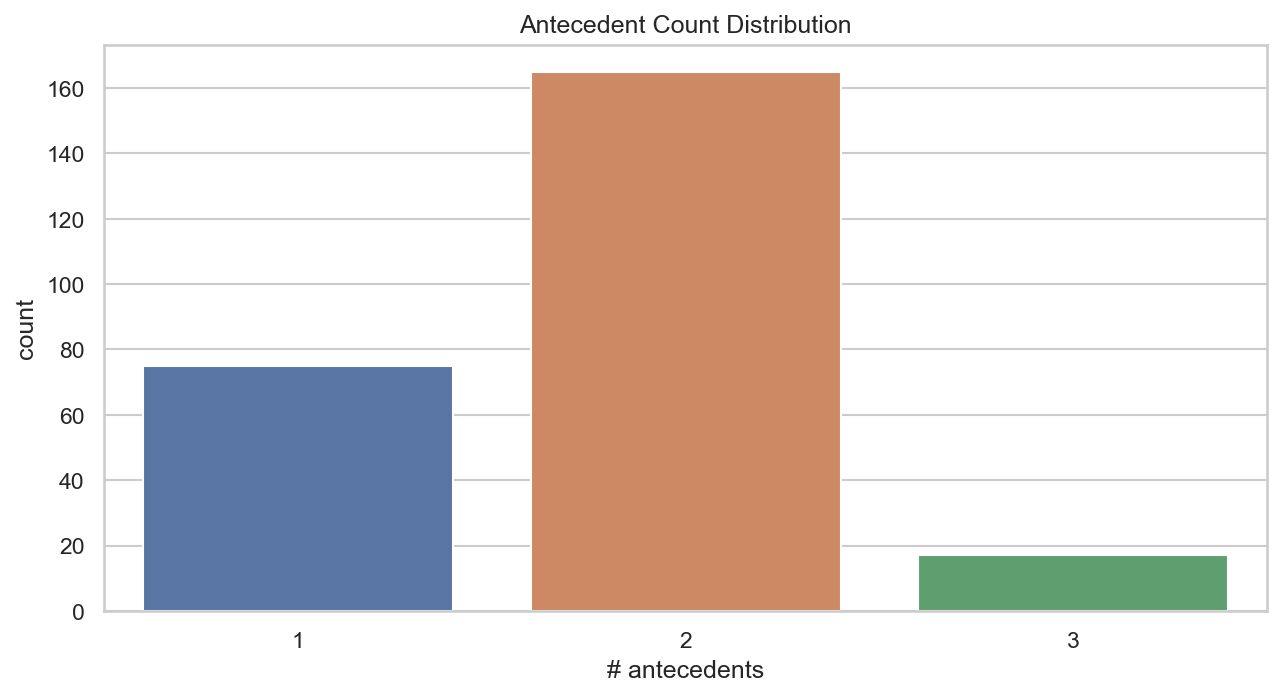

In [439]:
ax = plt.subplots(figsize=(10,5))
_ = sns.countplot(data=frequent_itemsets, x="# antecedents", ).set(title="Antecedent Count Distribution")
plt.show()

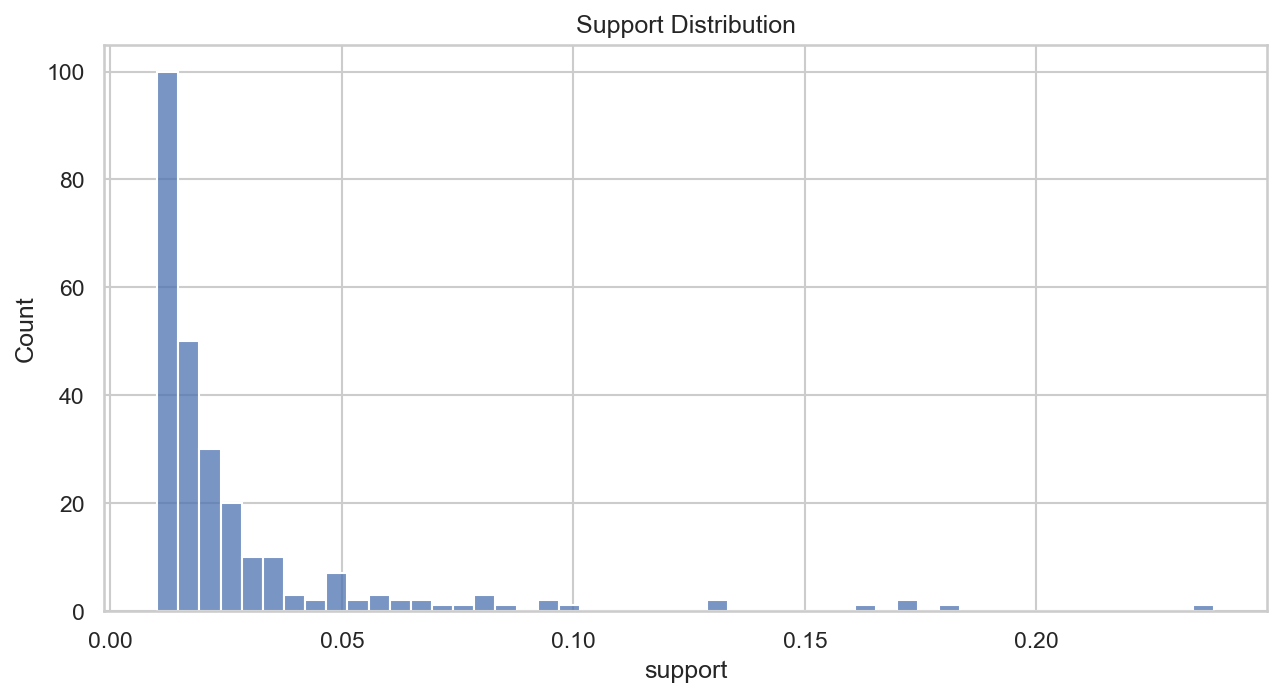

In [440]:
ax = plt.subplots(figsize=(10,5))
_ = sns.histplot(data=frequent_itemsets, x="support").set(title="Support Distribution")

#### Compute all association rules

In [407]:
# Compute all association rules for frequent_itemsets
# rules = association_rules(df=frequent_itemsets, metric = "lift", min_threshold = 0.8)
# rules

# association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)
association_rules(frequent_itemsets,  min_threshold=0)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(VIVO Dual LCD Monitor Desk mount),(Dust-Off Compressed Gas 2 pack),0.17,0.24,0.06,0.34,1.44,0.02,1.16
1,(Dust-Off Compressed Gas 2 pack),(VIVO Dual LCD Monitor Desk mount),0.24,0.17,0.06,0.25,1.44,0.02,1.10
2,(HP 61 ink),(Dust-Off Compressed Gas 2 pack),0.16,0.24,0.05,0.32,1.35,0.01,1.12
3,(Dust-Off Compressed Gas 2 pack),(HP 61 ink),0.24,0.16,0.05,0.22,1.35,0.01,1.07
4,(Apple Pencil),(Dust-Off Compressed Gas 2 pack),0.18,0.24,0.05,0.28,1.19,0.01,1.06
5,(Dust-Off Compressed Gas 2 pack),(Apple Pencil),0.24,0.18,0.05,0.21,1.19,0.01,1.04


In [406]:
# Compute all association rules for frequent_itemsets
rules = association_rules(df=frequent_itemsets, metric = "support", min_threshold = 0)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(VIVO Dual LCD Monitor Desk mount),(Dust-Off Compressed Gas 2 pack),0.17,0.24,0.06,0.34,1.44,0.02,1.16
1,(Dust-Off Compressed Gas 2 pack),(VIVO Dual LCD Monitor Desk mount),0.24,0.17,0.06,0.25,1.44,0.02,1.10
2,(HP 61 ink),(Dust-Off Compressed Gas 2 pack),0.16,0.24,0.05,0.32,1.35,0.01,1.12
3,(Dust-Off Compressed Gas 2 pack),(HP 61 ink),0.24,0.16,0.05,0.22,1.35,0.01,1.07
4,(Apple Pencil),(Dust-Off Compressed Gas 2 pack),0.18,0.24,0.05,0.28,1.19,0.01,1.06
5,(Dust-Off Compressed Gas 2 pack),(Apple Pencil),0.24,0.18,0.05,0.21,1.19,0.01,1.04


In [408]:
association_rules(df=frequent_itemsets, min_threshold = 0)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(VIVO Dual LCD Monitor Desk mount),(Dust-Off Compressed Gas 2 pack),0.17,0.24,0.06,0.34,1.44,0.02,1.16
1,(Dust-Off Compressed Gas 2 pack),(VIVO Dual LCD Monitor Desk mount),0.24,0.17,0.06,0.25,1.44,0.02,1.10
2,(HP 61 ink),(Dust-Off Compressed Gas 2 pack),0.16,0.24,0.05,0.32,1.35,0.01,1.12
3,(Dust-Off Compressed Gas 2 pack),(HP 61 ink),0.24,0.16,0.05,0.22,1.35,0.01,1.07
4,(Apple Pencil),(Dust-Off Compressed Gas 2 pack),0.18,0.24,0.05,0.28,1.19,0.01,1.06
5,(Dust-Off Compressed Gas 2 pack),(Apple Pencil),0.24,0.18,0.05,0.21,1.19,0.01,1.04


In [466]:
# There is a little cleanup, we need to do. First, some of the descriptions have spaces that need to be removed. We’ll also drop the rows that don’t have invoice numbers and remove the credit transactions (those with invoice numbers containing C).

# strip whitespace
# df['Description'] = df['Description'].str.strip()
# df.dropna(axis=0, subset=['InvoiceNo'], inplace=True)
# df['InvoiceNo'] = df['InvoiceNo'].astype('str')
# df = df[~df['InvoiceNo'].str.contains('C')]

q = pd.DataFrame({"123": "   foo   "}, index=[0])
q.values

df_obj = q.select_dtypes(['object'])
# print (df_obj)
# 0    a  
# 1    c  

# q[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())
# print (df)

x = df_obj.apply(lambda x: x.str.strip())
x.values

array([['   foo   ']], dtype=object)

array([['foo']], dtype=object)

In [ ]:
# validate that there aren't typos in item names

In [ ]:
# After the cleanup, we need to consolidate the items into 1 transaction per row with each product 1 hot encoded. For the sake of keeping the data set small, I’m only looking at sales for France. However, in additional code below, I will compare these results to sales from Germany. Further country comparisons would be interesting to investigate.

basket = (df[df['Country'] =="France"]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

In [ ]:
# There are a lot of zeros in the data but we also need to make sure any positive values are converted to a 1 and anything less the 0 is set to 0. This step will complete the one hot encoding of the data and remove the postage column (since that charge is not one we wish to explore):

def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units)
basket_sets.drop('POSTAGE', inplace=True, axis=1)

In [ ]:
# Now that the data is structured properly, we can generate frequent item sets that have a support of at least 7% (this number was chosen so that I could get enough useful examples):

frequent_itemsets = apriori(basket_sets, min_support=0.07, use_colnames=True)


In [ ]:
# The final step is to generate the rules with their corresponding support, confidence and lift:

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.head()

In [ ]:
# Now, the tricky part is figuring out what this tells us. For instance, we can see that there are quite a few rules with a high lift value which means that it occurs more frequently than would be expected given the number of transaction and product combinations. We can also see several where the confidence is high as well. This part of the analysis is where the domain knowledge will come in handy. 

In [ ]:
# We can filter the dataframe using standard pandas code. In this case, look for a large lift (6) and high confidence (.8):

rules[ (rules['lift'] >= 6) &
       (rules['confidence'] >= 0.8) ]


# In looking at the rules, it seems that the green and red alarm clocks are purchased together and the red paper cups, napkins and plates are purchased together in a manner that is higher than the overall probability would suggest.

In [ ]:
# At this point, you may want to look at how much opportunity there is to use the popularity of one product to drive sales of another. For instance, we can see that we sell 340 Green Alarm clocks but only 316 Red Alarm Clocks so maybe we can drive more Red Alarm Clock sales through recommendations?

basket['ALARM CLOCK BAKELIKE GREEN'].sum()

340.0

basket['ALARM CLOCK BAKELIKE RED'].sum()

316.0


### 2.  Execute the code used to generate association rules with the Apriori algorithm. Provide screenshots that demonstrate the error-free functionality of the code.



### 3.  Provide values for the support, lift, and confidence of the association rules table.


### 4.  Identify the top three rules generated by the Apriori algorithm. Include a screenshot of the top rules along with their summaries.
- DATACAMP
    - Apriori principle.
        - Subsets of frequent sets are frequent.
        - Retain sets known to be frequent.
        - Prune sets not known to be frequent.
    - Apriori prunes itemsets.
        - Applies minimum support threshold.
        - Modified version can prune by number of items.
        - Doesn't tell us about association rules.


# Part IV: Data Summary and Implications

## D.  Summarize your data analysis by doing the following:
### 1.  Summarize the significance of support, lift, and confidence from the results of the analysis.

In [312]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth
from mlxtend.frequent_patterns import association_rules


dataset = [['Milk', 'Onion', 'Nutmeg', 'Kidney Beans', 'Eggs', 'Yogurt'],
           ['Dill', 'Onion', 'Nutmeg', 'Kidney Beans', 'Eggs', 'Yogurt'],
           ['Milk', 'Apple', 'Kidney Beans', 'Eggs'],
           ['Milk', 'Unicorn', 'Corn', 'Kidney Beans', 'Yogurt'],
           ['Corn', 'Onion', 'Onion', 'Kidney Beans', 'Ice cream', 'Eggs']]

te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
df = pd.DataFrame(te_ary, columns=te.columns_)

frequent_itemsets = fpgrowth(df, min_support=0.6, use_colnames=True)
### alternatively:
# frequent_itemsets = apriori(df, min_support=0.6, use_colnames=True)
# frequent_itemsets = fpmax(df, min_support=0.6, use_colnames=True)

frequent_itemsets



association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)
rules
rules["antecedent_len"] = rules["antecedents"].apply(lambda x: len(x))
rules

,support,itemsets
0,1.00,(Kidney Beans)
1,0.80,(Eggs)
2,0.60,(Yogurt)
3,0.60,(Onion)
4,0.60,(Milk)
5,0.80,"(Kidney Beans, Eggs)"
6,0.60,"(Yogurt, Kidney Beans)"
7,0.60,"(Onion, Eggs)"
8,0.60,"(Kidney Beans, Onion)"
9,0.60,"(Kidney Beans, Onion, Eggs)"


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Kidney Beans),(Eggs),1.00,0.80,0.80,0.80,1.00,0.00,1.00
1,(Eggs),(Kidney Beans),0.80,1.00,0.80,1.00,1.00,0.00,inf
2,(Yogurt),(Kidney Beans),0.60,1.00,0.60,1.00,1.00,0.00,inf
3,(Onion),(Eggs),0.60,0.80,0.60,1.00,1.25,0.12,inf
4,(Eggs),(Onion),0.80,0.60,0.60,0.75,1.25,0.12,1.60
5,(Onion),(Kidney Beans),0.60,1.00,0.60,1.00,1.00,0.00,inf
6,"(Kidney Beans, Onion)",(Eggs),0.60,0.80,0.60,1.00,1.25,0.12,inf
7,"(Kidney Beans, Eggs)",(Onion),0.80,0.60,0.60,0.75,1.25,0.12,1.60
8,"(Onion, Eggs)",(Kidney Beans),0.60,1.00,0.60,1.00,1.00,0.00,inf
9,(Onion),"(Kidney Beans, Eggs)",0.60,0.80,0.60,1.00,1.25,0.12,inf


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Onion),(Eggs),0.60,0.80,0.60,1.00,1.25,0.12,inf
1,(Eggs),(Onion),0.80,0.60,0.60,0.75,1.25,0.12,1.60
2,"(Kidney Beans, Onion)",(Eggs),0.60,0.80,0.60,1.00,1.25,0.12,inf
3,"(Kidney Beans, Eggs)",(Onion),0.80,0.60,0.60,0.75,1.25,0.12,1.60
4,(Onion),"(Kidney Beans, Eggs)",0.60,0.80,0.60,1.00,1.25,0.12,inf
5,(Eggs),"(Kidney Beans, Onion)",0.80,0.60,0.60,0.75,1.25,0.12,1.60


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
0,(Onion),(Eggs),0.60,0.80,0.60,1.00,1.25,0.12,inf,1
1,(Eggs),(Onion),0.80,0.60,0.60,0.75,1.25,0.12,1.60,1
2,"(Kidney Beans, Onion)",(Eggs),0.60,0.80,0.60,1.00,1.25,0.12,inf,2
3,"(Kidney Beans, Eggs)",(Onion),0.80,0.60,0.60,0.75,1.25,0.12,1.60,2
4,(Onion),"(Kidney Beans, Eggs)",0.60,0.80,0.60,1.00,1.25,0.12,inf,1
5,(Eggs),"(Kidney Beans, Onion)",0.80,0.60,0.60,0.75,1.25,0.12,1.60,1


#### Support
- https://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/
    - support(A→C)=support(A∪C),range: [0,1]
    - The support metric is defined for itemsets, not assocication rules. The table produced by the association rule mining algorithm contains three different support metrics: 'antecedent support', 'consequent support', and 'support'. Here, 'antecedent support' computes the proportion of transactions that contain the antecedent A, and 'consequent support' computes the support for the itemset of the consequent C. The 'support' metric then computes the support of the combined itemset A ∪ C -- note that 'support' depends on 'antecedent support' and 'consequent support' via min('antecedent support', 'consequent support').
    - Typically, support is used to measure the abundance or frequency (often interpreted as significance or importance) of an itemset in a database. We refer to an itemset as a "frequent itemset" if you support is larger than a specified minimum-support threshold. Note that in general, due to the downward closure property, all subsets of a frequent itemset are also frequent.
    
- https://pbpython.com/market-basket-analysis.html
    - Support is the relative frequency that the rules show up. In many instances, you may want to look for high support in order to make sure it is a useful relationship. However, there may be instances where a low support is useful if you are trying to find “hidden” relationships.
    
- DATACAMP
    - The support metric measures the share of transactions that contain an itemset.
        - number of transactions with items(s) / number of transactions

- The significance of Support from the analysis results is        

#### Lift
- https://pbpython.com/market-basket-analysis.html
    - Lift is the ratio of the observed support to that expected if the two rules were independent (see wikipedia). The basic rule of thumb is that a lift value close to 1 means the rules were completely independent. Lift values > 1 are generally more “interesting” and could be indicative of a useful rule pattern.
    - The lift metric is commonly used to measure how much more often the antecedent and consequent of a rule A->C occur together than we would expect if they were statistically independent. If A and C are independent, the Lift score will be exactly 1.
    
- (https://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/)
    - Rule generation is a common task in the mining of frequent patterns. An association rule is an implication expression of the form X→Y, where X and Y are disjoint itemsets. A more concrete example based on consumer behaviour would be {Diapers}→{Beer} suggesting that people who buy diapers are also likely to buy beer. To evaluate the "interest" of such an association rule, different metrics have been developed. The current implementation make use of the confidence and lift metrics.
    - The currently supported metrics for evaluating association rules and setting selection thresholds are listed below. Given a rule "A -> C", A stands for antecedent and C stands for consequent.

- DATACAMP
    - Lift provides another metric for evaluating the relationship between items.
    - Support(X&Y) / (Support(X) * Support(Y))
        - Numerator: Proportion of transactions that contain X and Y.
        - Denominator: Proportion if X and Y assigned randomly and independently.
        
- The significance of Lift from the analysis results is        



#### Confidence
- https://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/
    - The confidence of a rule A->C is the probability of seeing the consequent in a transaction given that it also contains the antecedent. Note that the metric is not symmetric or directed; for instance, the confidence for A->C is different than the confidence for C->A. The confidence is 1 (maximal) for a rule A->C if the consequent and antecedent always occur together.

- https://pbpython.com/market-basket-analysis.html
    - Confidence is a measure of the reliability of the rule. A confidence of .5 in the above example would mean that in 50% of the cases where Diaper and Gum were purchased, the purchase also included Beer and Chips. For product recommendation, a 50% confidence may be perfectly acceptable but in a medical situation, this level may not be high enough.

- DATACAMP
    - 1. Can improve over support with additional metrics.
    - Adding con,dence provides a more complete picture.
    - Support(X&Y) / Support(X)
    
- The significance of Confidence from the analysis results is


### 2.  Discuss the practical significance of the findings from the analysis.
- The significance of the analysis findings is



### 3.  Recommend a course of action for the real-world organizational situation from part A1 based on your results from part D1.
- My recommended course of action based on the analysis findings is
 

# Part V: Attachments

## E.  Provide a Panopto video recording that includes a demonstration of the functionality of the code used for the analysis and a summary of the programming environment.
 

Note: The audiovisual recording should feature you visibly presenting the material (i.e., not in voiceover or embedded video) and should simultaneously capture both you and your multimedia presentation.
 

Note: For instructions on how to access and use Panopto, use the "Panopto How-To Videos" web link provided below. To access Panopto's website, navigate to the web link titled "Panopto Access," and then choose to log in using the “WGU” option. If prompted, log in using your WGU student portal credentials, and then it will forward you to Panopto’s website.
 

To submit your recording, upload it to the Panopto drop box titled “Data Mining II – OFM3.” Once the recording has been uploaded and processed in Panopto's system, retrieve the URL of the recording from Panopto and copy and paste it into the Links option. Upload the remaining task requirements using the Attachments option.



## F.  Record all web sources used to acquire data or segments of third-party code to support the application. Ensure the web sources are reliable.
- https://pbpython.com/market-basket-analysis.html
- https://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/
- https://datascience.stackexchange.com/questions/58890/delete-drop-only-the-rows-which-has-all-values-as-nan-in-pandas
- https://stackoverflow.com/questions/45424687/how-to-make-list-of-lists-from-pandas-dataframe-skipping-nan-values
- https://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/
- https://stackoverflow.com/questions/36786722/how-to-display-full-output-in-jupyter-not-only-last-result
- https://stackoverflow.com/questions/34238391/convert-one-dataframe-row-to-flat-list

## G.  Acknowledge sources, using in-text citations and references, for content that is quoted, paraphrased, or summarized.
- https://pbpython.com/market-basket-analysis.html